# Packages

In [1]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import sklearn
import os
import gc #garbage collector
import random #random seed generator
import sys
import csv
import subprocess

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import numpy as np    #numerical package

#Sci-kit Learn
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.metrics import classification_report as cr
from sklearn.model_selection import train_test_split as tts

#Tensorflow
import tensorflow as tf #backend for keras
from tensorflow.python.client import device_lib #to  see if my GPU is alive!
import tensorflow.keras #keras
from tensorflow.keras import Sequential,Input,Model #pull in the sequential, input layers and a model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Embedding, Bidirectional, Dense, LSTM, Concatenate, concatenate #pull in the dense, dropout, and flatten layers
from tensorflow.keras.layers import Add, Activation, ZeroPadding2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint # ReduceLROnPlateau, use for early stopping and reduction on level-out
from tensorflow.keras import utils #Need utilities for the layers
from tensorflow.keras.utils import get_file, plot_model #To load certain files & plot models
import tensorflow.keras.backend as K #To write our own metrics and loss functions
from tensorflow.keras.preprocessing.text import Tokenizer #RNN
from tensorflow.keras.preprocessing.sequence import pad_sequences #RNN

#Graphing
import matplotlib #image save
import matplotlib.pyplot as plt #plotting
from matplotlib.pyplot import imshow #Show images
from PIL import Image, ImageFont, ImageDraw

%matplotlib inline

#Verify GPU recognition
print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
##############################################################################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8266814282178939333
xla_global_id: -1
]


# Clean Up Function

In [2]:
#################################################Memory Mgt / Directory Load###################################################
def reset_keras():
    tf.keras.backend.clear_session #This clears the GPU session
    gc.collect()
reset_keras()
################################################################################################################################

# Data Load

In [3]:
one = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/one.csv') #read original data
two = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/two.csv') #read original data
three = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/three.csv') #read original data
four = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/four.csv') #read original data
mydf=[one,two,three,four]
mydf=pd.concat(mydf)
mydf=pd.DataFrame(mydf)
mydf.columns=['Search', 'Action', 'Pages']
mydf

,Search,Action,Pages
0,#AN=2005-13342-017&db=pdh Title: Role Taking o...,E-mail,0.0
1,Search Term: HRSA Developing and Implementing ...,"Expanders: Apply related words , Expanders: Al...",0.0
2,#AN=edsgcl.224856267&db=edsggo Title: Research...,Cite,0.0
3,Search Term: creating intergenerational spaces...,Title: The World Health Organization (WHO) app...,0.0
4,Search Term: legitimate leadership,Title: Using Leadership Power Wisely.,0.0
...,...,...,...
749995,Search Term: Positive classroom environments,"Source Types: Academic Journals ,",19.0
749996,671653c8-2ccc-4504-b44b-4fe4c2f02b96%40redis,yoga treatment AND trauma,19.0
749997,Search Term: physical literacy,"Limiters: Full Text , Limiters: Scholarly (Pee...",19.0
749998,9fef893e-07e3-4b9e-91ad-ba879ad664f4%40redis,teacher pedagogy AND teaching about slavery AN...,19.0


# Recode DV

In [5]:
tmp=mydf['Pages'].astype('int')
tmp[tmp<=1]=0
tmp[(tmp>1) & (tmp<=10)]=3  # Use parentheses to group conditions
tmp[(tmp>10) & (tmp<=27)]=2
tmp[tmp>27]=1
mydf['Pages']=tmp
mydf
del tmp    # you may want to collapse 2 and 3...lot's of confusion there

# Clean & Concatenate

In [6]:
reset_keras()
mydf['All']=mydf['Search']+' '+mydf['Action']
mydf=mydf.drop(['Search','Action'],axis=1)
reset_keras()
mydf

,Pages,All
0,0,#AN=2005-13342-017&db=pdh Title: Role Taking o...
1,0,Search Term: HRSA Developing and Implementing ...
2,0,#AN=edsgcl.224856267&db=edsggo Title: Research...
3,0,Search Term: creating intergenerational spaces...
4,0,Search Term: legitimate leadership Title: Usin...
...,...,...
749995,2,Search Term: Positive classroom environments S...
749996,2,671653c8-2ccc-4504-b44b-4fe4c2f02b96%40redis y...
749997,2,Search Term: physical literacy Limiters: Full ...
749998,2,9fef893e-07e3-4b9e-91ad-ba879ad664f4%40redis t...


# Drop and Clean

In [9]:
mydf['All']=mydf['All'].astype(str)
mydf['All'] = mydf['All'].str.replace('Search', '')
mydf['All'] = mydf['All'].str.replace('Term', '')
mydf['All'] = mydf['All'].str.replace('search', '')
mydf['All'] = mydf['All'].str.replace('expanders', '')
mydf.to_csv('/content/drive/MyDrive/Colab Notebooks/total.csv',index=False)
mydf  # you will want to manipulate other terms and words that you drop

,Pages,All
0,0,#AN=2005-13342-017&db=pdh Title: Role Taking o...
1,0,: HRSA Developing and Implementing a Quality ...
2,0,#AN=edsgcl.224856267&db=edsggo Title: Re and M...
3,0,: creating intergenerational spaces that prom...
4,0,: legitimate leadership Title: Using Leadersh...
...,...,...
749995,2,: Positive classroom environments Source Type...
749996,2,671653c8-2ccc-4504-b44b-4fe4c2f02b96%40redis y...
749997,2,": physical literacy Limiters: Full Text , Lim..."
749998,2,9fef893e-07e3-4b9e-91ad-ba879ad664f4%40redis t...


In [10]:
mydf=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/total.csv')

# Inverse Weight

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=.05, analyzer='word', stop_words="english", ngram_range=(1,3)) # play with this most definitely!
all = vectorizer.fit_transform(mydf['All'])

# Save Labels

In [12]:
mylabels=vectorizer.get_feature_names_out()
print(mylabels,len(mylabels))  # I reduced to 53 ngrams of size 1 to 3 that occurred at least 5% of the time...You need to play with the delimiters.

['40redis' 'apply' 'apply equivalent' 'apply equivalent subjects'
 'apply related' 'apply related words' 'articles' 'articles expanders'
 'articles expanders apply' 'cite' 'date' 'db' 'equivalent'
 'equivalent subjects' 'expanders' 'expanders apply'
 'expanders apply equivalent' 'expanders apply related' 'expanders text'
 'expanders text articles' 'journals' 'limiters' 'limiters published'
 'limiters published date' 'limiters scholarly' 'limiters scholarly peer'
 'limiters text' 'limiters text limiters' 'peer' 'peer reviewed'
 'peer reviewed journals' 'published' 'published date' 'related'
 'related words' 'related words expanders' 'reviewed' 'reviewed journals'
 'scholarly' 'scholarly peer' 'scholarly peer reviewed' 'subjects' 'text'
 'text articles' 'text articles expanders' 'text limiters'
 'text limiters scholarly' 'title' 'undefined' 'undefined title' 'words'
 'words expanders' 'words expanders text'] 53


# Split

In [13]:
x_train, x_test, y_train, y_test = tts(all, mydf['Pages'], test_size=0.2, random_state=42) #split
print(x_train.shape)      #print x training columns
y_test[np.isnan(y_test)] = 1
y_train[np.isnan(y_train)] = 1

(2400000, 53)


In [14]:
np.unique(y_train, return_counts=True)  # still a small number of 0's

(array([0, 1, 2, 3]), array([  44755,  218982,  973493, 1162770]))

# Rebalance

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
under=RUS()
x_train_resampled, y_train_resampled = under.fit_resample(x_train, y_train)

In [16]:
x_train_resampled.shape

(179020, 53)

# Fit NB

In [25]:
classifier = MultinomialNB()
classifier.fit(x_train_resampled, y_train_resampled)
y_pred = classifier.predict(x_test)
print(cr(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.82      0.05     11000
           1       0.11      0.23      0.15     54964
           2       0.46      0.17      0.25    243572
           3       0.55      0.00      0.00    290464

    accuracy                           0.11    600000
   macro avg       0.28      0.31      0.11    600000
weighted avg       0.46      0.11      0.12    600000



In [29]:
from sklearn.linear_model import LogisticRegression as lr
c2=lr(multi_class='multinomial',solver ='newton-cg')
mylr=c2.fit(x_train_resampled, y_train_resampled)


In [34]:
print(mylr.coef_)
print(cr(y_test, mylr.predict(x_test)))

[[ 0.41172316 -0.49711813  0.32812372  0.32812372 -0.1973121  -0.1973121
   0.49963988 -1.08121148 -1.08121148 -0.35787814 -0.47149514 -0.59953285
   0.34267244  0.32812372 -0.72041762 -0.27482832  0.12517104 -0.40033164
  -0.4150902  -0.4150902  -1.81341634 -2.02037005 -1.55622054 -1.55622054
  -0.23352461 -0.23352461  1.31746514  0.12758957  0.32976012  0.40246014
   0.84320391  0.44229052 -1.55622054  0.72838949 -0.27269323  1.27727823
  -0.06261132  0.84320111  0.29401136  0.5761507   0.81124071  0.1319751
   0.46697853 -0.21205649 -1.30381223  0.05824725  0.92543585  0.85161845
  -0.75968735 -1.21412033  0.29395972  1.27727823  4.07243968]
 [-0.26138798  0.71904195 -0.11028973 -0.11028973  0.2182474   0.2182474
  -0.25457577  0.86006374  0.86006374 -0.29927441 -0.03958561  0.54664601
  -0.89448584 -0.11028973  0.25628743 -0.12673825 -0.22765941  0.10084961
   0.26864466  0.26864466  0.89044973  0.89539823  0.71848928  0.71848928
   0.21241509  0.21241509 -0.79728174  0.15547398 -0

# RF

In [51]:
from sklearn.ensemble import RandomForestClassifier as RFC
rf = RFC(max_depth=10, random_state=42,oob_score=True)
rf.fit(x_train_resampled, y_train_resampled)
print(cr(y_test, rf.predict(x_test)))


              precision    recall  f1-score   support

           0       0.03      0.55      0.06     11000
           1       0.12      0.27      0.17     54964
           2       0.46      0.17      0.25    243572
           3       0.50      0.31      0.38    290464

    accuracy                           0.26    600000
   macro avg       0.28      0.33      0.21    600000
weighted avg       0.44      0.26      0.30    600000



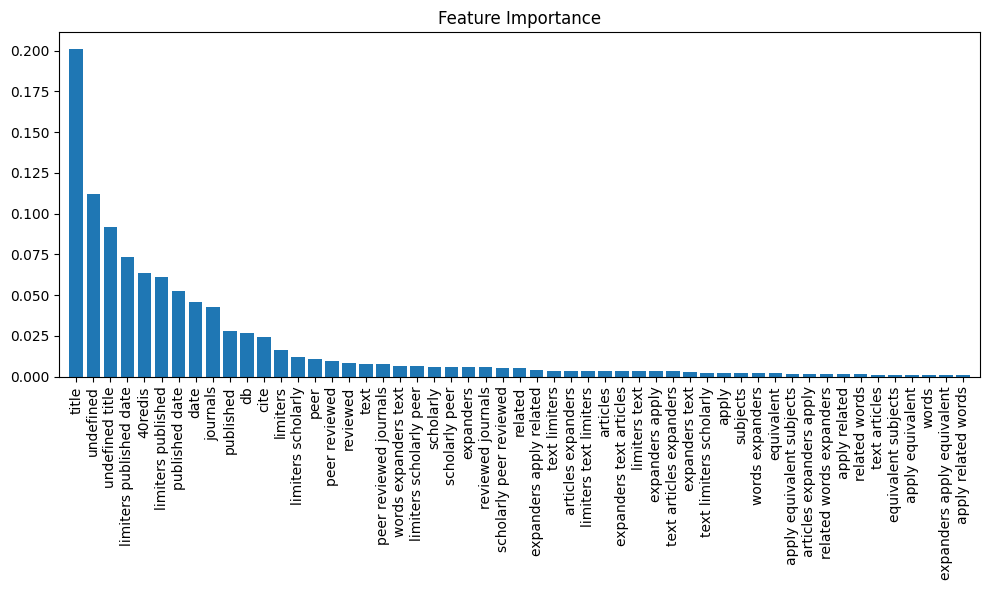

In [53]:
# Get feature importances

feature_names=mylabels
def myplot(importances):
  indices = np.argsort(importances)[::-1]
  # Plot feature importances
  plt.figure(figsize=(10, 6))
  plt.title("Feature Importance")
  plt.bar(range(x_train_resampled.shape[1]), importances[indices], align="center")
  plt.xticks(range(x_train_resampled.shape[1]), [feature_names[i] for i in indices], rotation=90)
  plt.xlim([-1, x_train_resampled.shape[1]])
  plt.tight_layout()
  plt.show()


myplot(rf.feature_importances_)

# Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbc = GBC(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42).fit(x_train_resampled, y_train_resampled)
print(cr(y_test, gbc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.03      0.54      0.06     11000
           1       0.12      0.27      0.17     54964
           2       0.46      0.17      0.25    243572
           3       0.50      0.31      0.39    290464

    accuracy                           0.26    600000
   macro avg       0.28      0.32      0.21    600000
weighted avg       0.44      0.26      0.30    600000



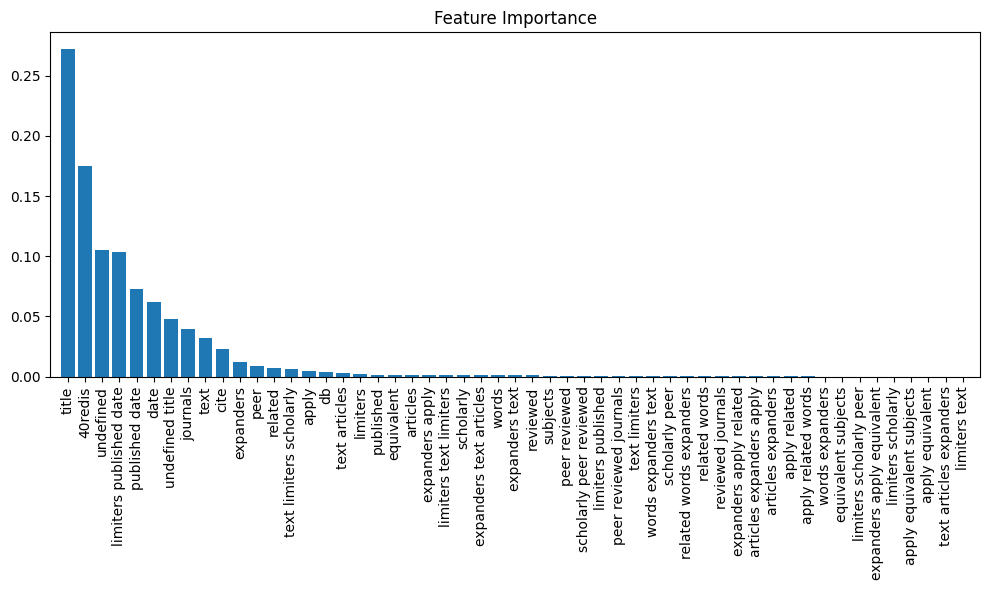

In [54]:
myplot(gbc.feature_importances_)

# Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc = DTC(random_state=42, max_depth=4).fit(x_train_resampled, y_train_resampled)
print(cr(y_test, dtc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.03      0.48      0.06     11000
           1       0.13      0.10      0.11     54964
           2       0.48      0.12      0.19    243572
           3       0.49      0.55      0.52    290464

    accuracy                           0.33    600000
   macro avg       0.28      0.31      0.22    600000
weighted avg       0.44      0.33      0.34    600000



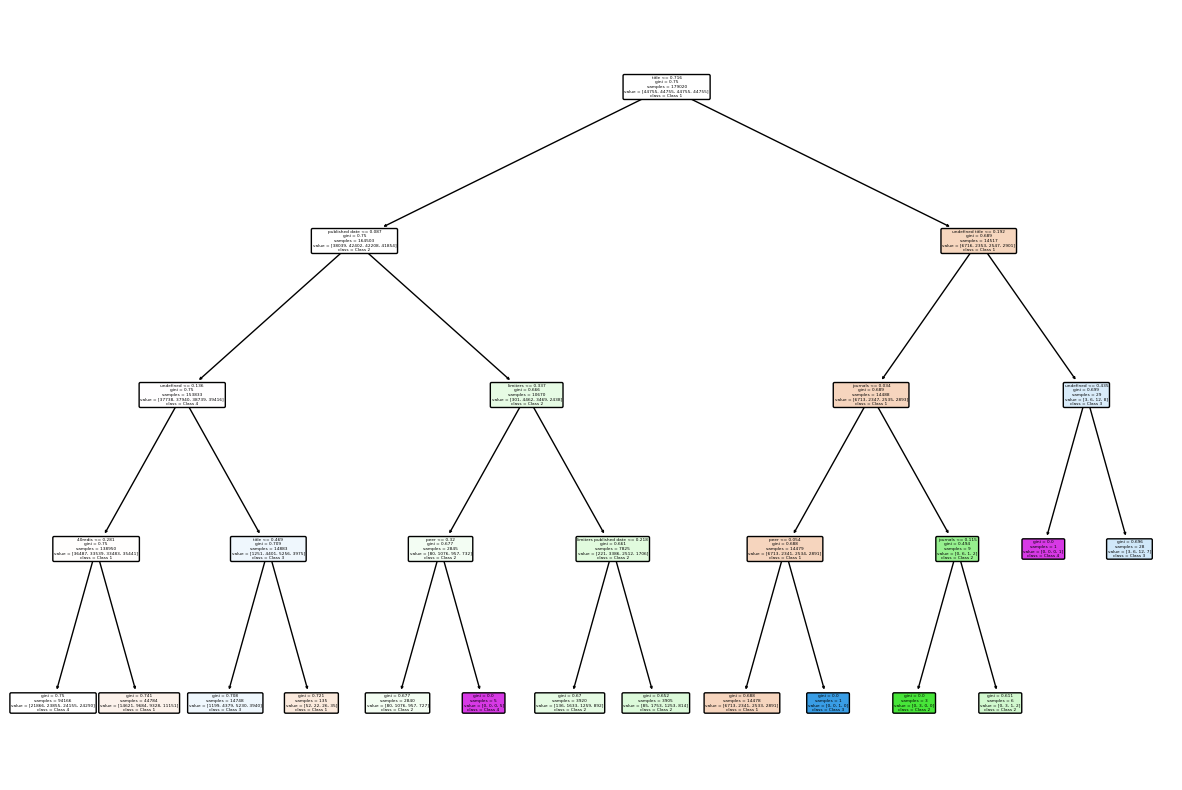

In [65]:
from sklearn import tree
plt.figure(figsize=(15, 10))
tree.plot_tree(dtc,
               feature_names=mylabels,
               filled=True,
               rounded=True,
               class_names=['Failure', 'Low Success','Moderate Succcess', 'Success']) # Replace with your class names
plt.show()

# Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', C=1.0, random_state=42).fit(x_train_resampled, y_train_resampled)
print(cr(y_test, svc.predict(x_test)))

# Perceptron

In [ ]:
from sklearn.linear_model import Perceptron as P
